In [1]:
import numpy as np

from TraceSimulator import TraceSimulator
from trace_IO import *
from OptimumFilter import *
from OF import *
import matplotlib.pyplot as plt


In [2]:
sampling_frequency = 3906250
template_1 = np.load("./sub_ch_template.npy")
template_2 = np.load("./vac_ch45_low_eng.npy")
template_3 = np.load("./vac_ch46plus_low_eng.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")

# Initialize Optimum Filter
trigger_1 = OFtrigger(template_1, noise_psd, sampling_frequency)
trigger_2 = OFtrigger(template_2, noise_psd, sampling_frequency)
trigger_3 = OFtrigger(template_3, noise_psd, sampling_frequency)
loaded_traces = load_traces_from_zstd("/ceph/dwong/trigger_samplesMMC_noise_1000.zst", n_traces=1000)
loaded_traces.shape

(1000, 54, 32768)

In [4]:
max_amp = -np.inf
max_trace_idx = -1
max_ch = -1

for trace_idx, traces in enumerate(loaded_traces):  # Loop over 1000 trace sets
    amps = np.zeros(54)
    chisqs = np.zeros(54)

    for ch in range(54):  # Loop over 54 channels
        if ch <= 44:
            amp, chisq = trigger_1.fit(traces[ch])
        elif ch == 45:
            amp, chisq = trigger_2.fit(traces[ch])
        else:
            amp, chisq = trigger_3.fit(traces[ch])

        amps[ch] = amp
        chisqs[ch] = chisq

        # Check for max amplitude
        if amp > max_amp:
            max_amp = amp
            max_trace_idx = trace_idx
            max_ch = ch

print(f"Max amplitude: {max_amp:.3f} found in trace set {max_trace_idx}, channel {max_ch}")


Max amplitude: 2.912 found in trace set 54, channel 13


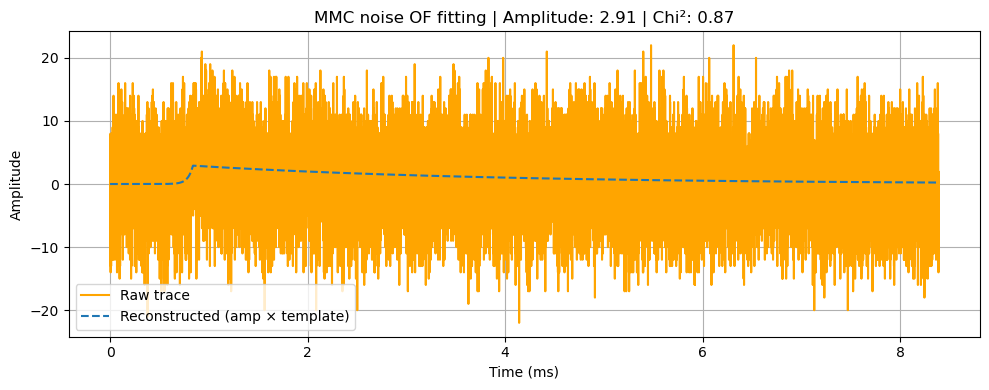

In [12]:
import matplotlib.pyplot as plt

ch = 13
trace = loaded_traces[54][ch]

# Choose the correct trigger and template
amp, chisq = trigger_1.fit(trace)
template = trigger_1._template
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # time per sample in ms
time_ms = np.arange(len(trace)) * dt_ms

# Choose the correct trigger and template
amp, chisq = trigger_1.fit(trace)
template = trigger_1._template

# Plot
plt.figure(figsize=(10, 4))
plt.plot(time_ms, trace, label=f'Raw trace', color = "orange")
plt.plot(time_ms, amp * template, label='Reconstructed (amp × template)', linestyle='--')
plt.title(f'MMC noise OF fitting | Amplitude: {amp:.2f} | Chi²: {chisq*4:.2f}')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
traces = loaded_traces[10]
amps = np.zeros(54)
chisqs = np.zeros(54)
t0s = np.zeros(54, dtype=int)

for ch in range(54):
    if ch <= 44:
        amp, chisq= trigger_1.fit(traces[ch])
    elif ch == 45:
        amp, chisq= trigger_2.fit(traces[ch])
    else:
        amp, chisq= trigger_3.fit(traces[ch])

    amps[ch] = amp
    chisqs[ch] = chisq


In [10]:
loaded_traces.shape

(1000, 54, 32768)

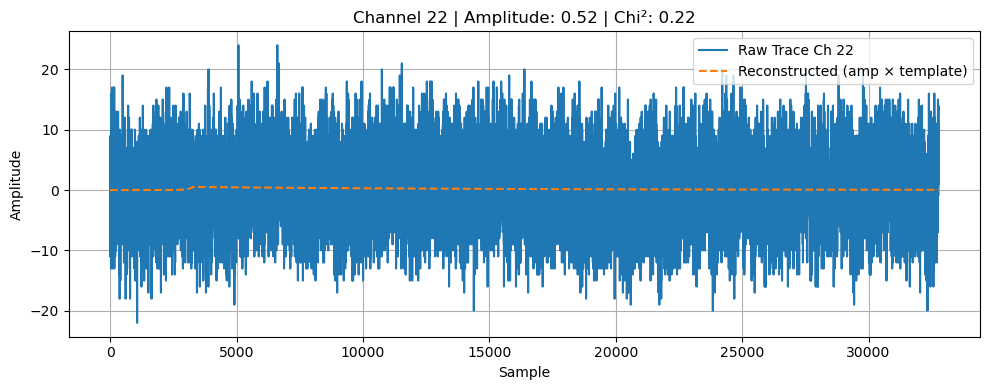

In [5]:
import matplotlib.pyplot as plt

ch = 22
trace = loaded_traces[0][ch]

# Choose the correct trigger and template
amp, chisq = trigger_1.fit(trace)
template = trigger_1._template

# Plot raw trace and reconstructed signal
plt.figure(figsize=(10, 4))
plt.plot(trace, label=f'Raw Trace Ch {ch}')
plt.plot(amp * template, label='Reconstructed (amp × template)', linestyle='--')
plt.title(f'Channel {ch} | Amplitude: {amp:.2f} | Chi²: {chisq:.2f}')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


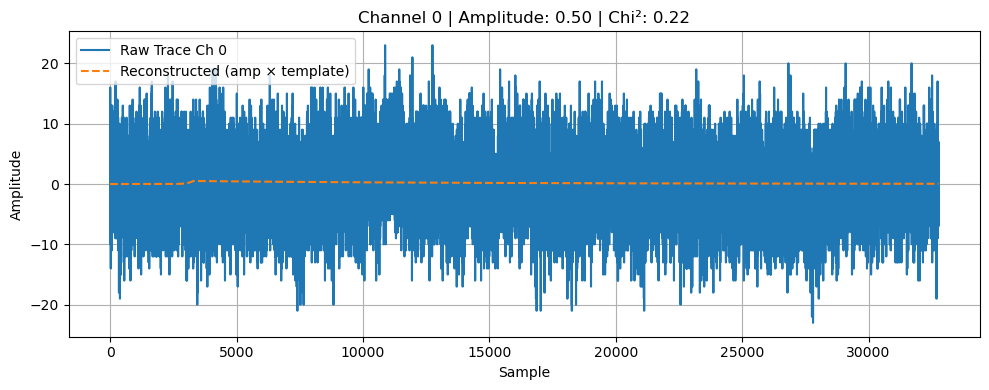

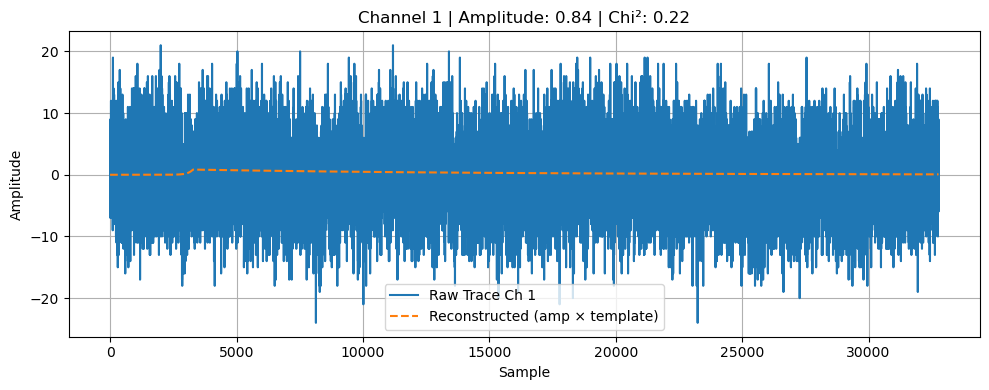

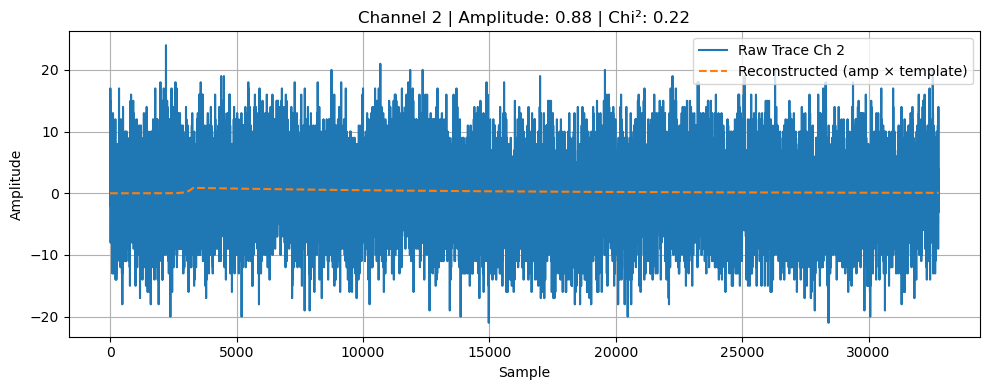

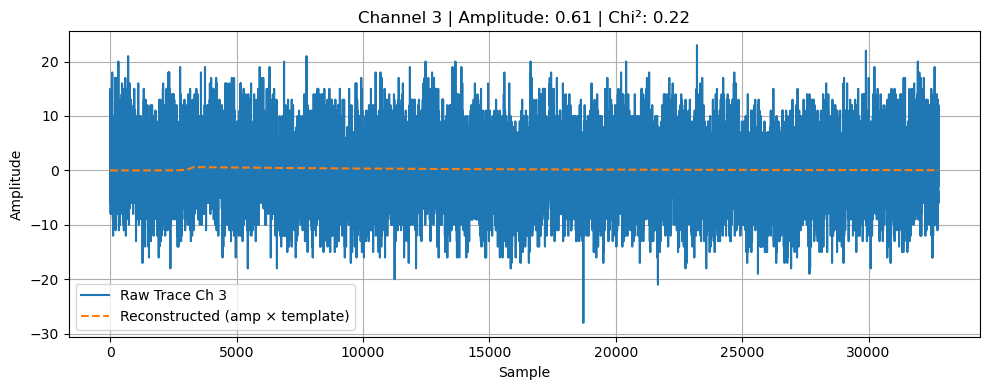

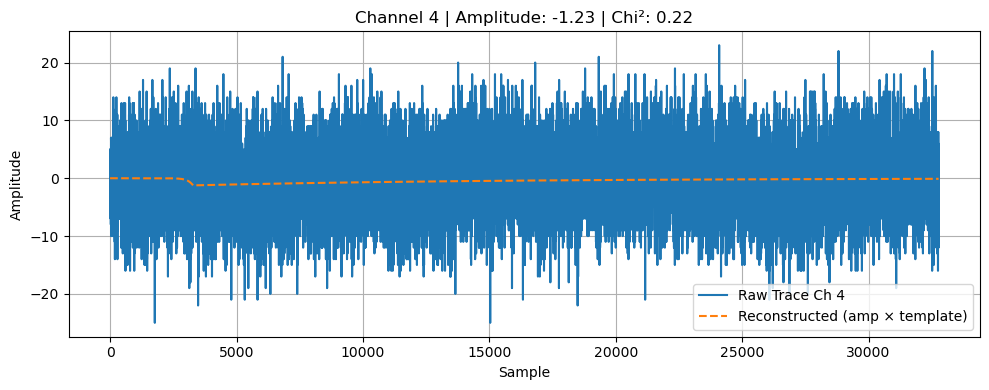

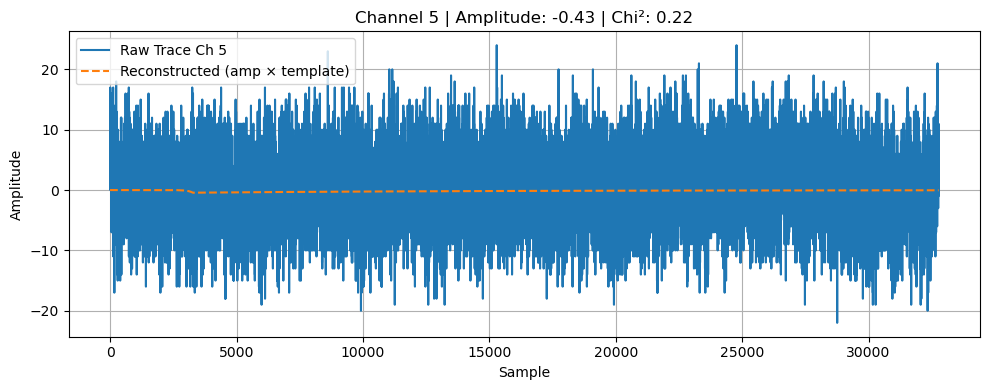

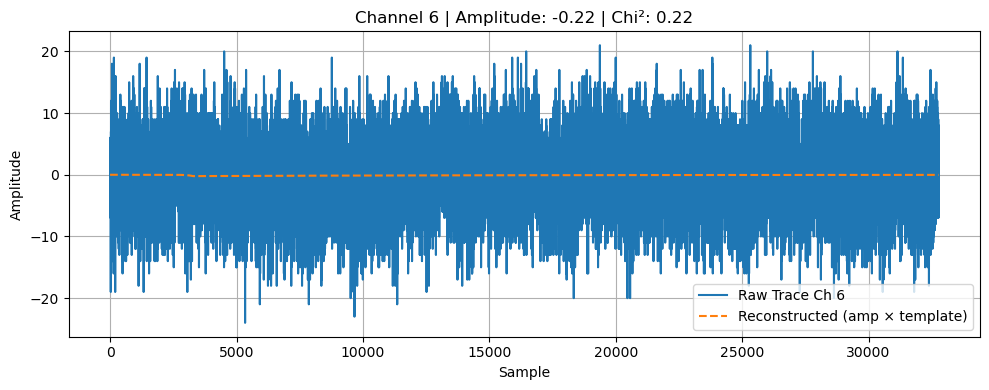

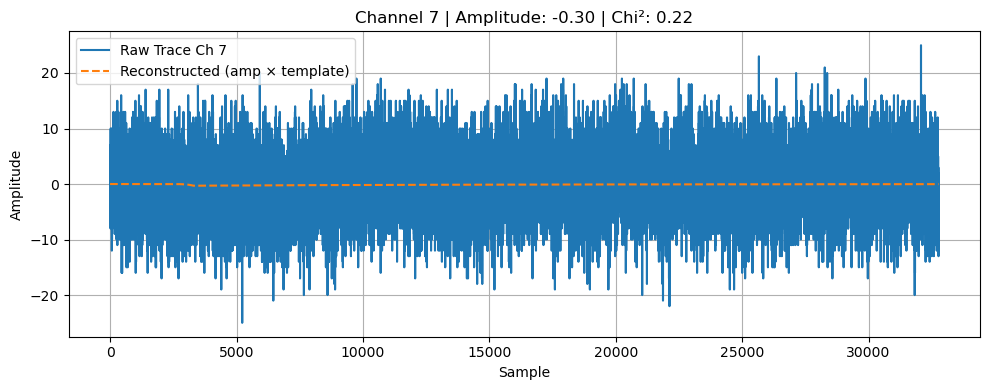

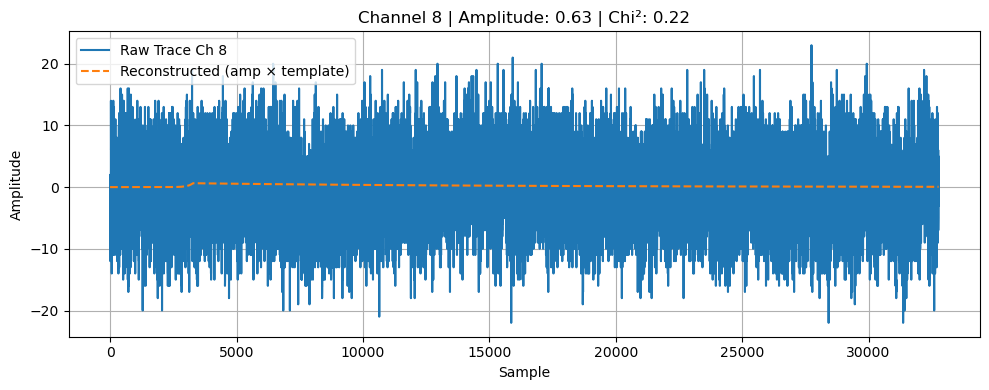

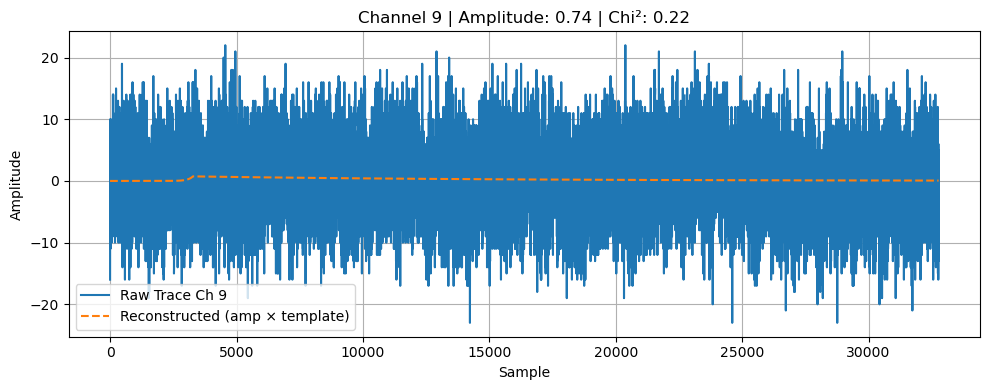

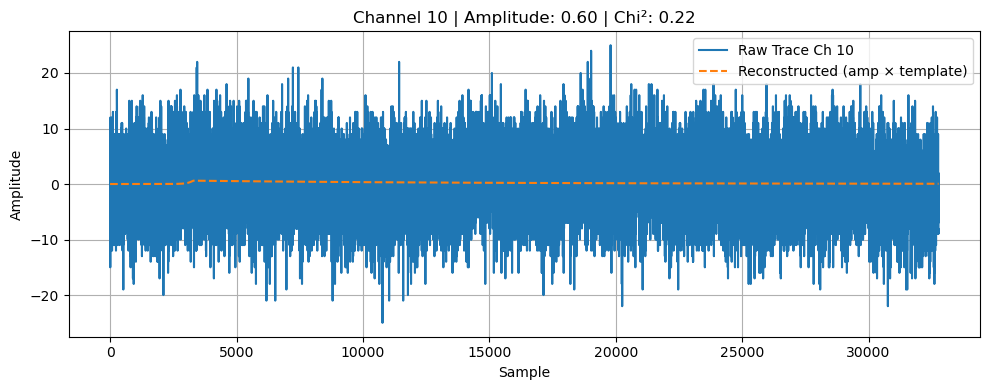

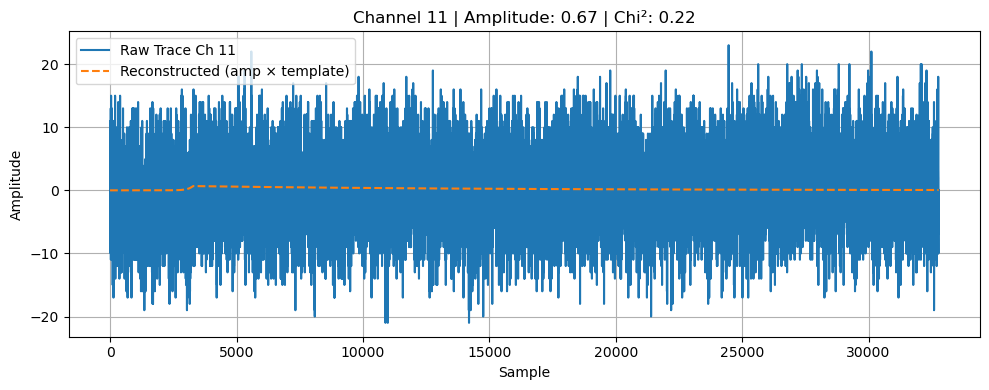

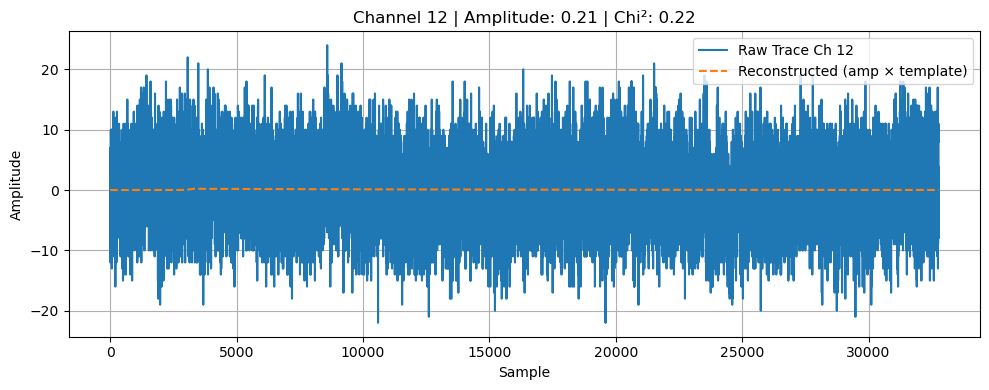

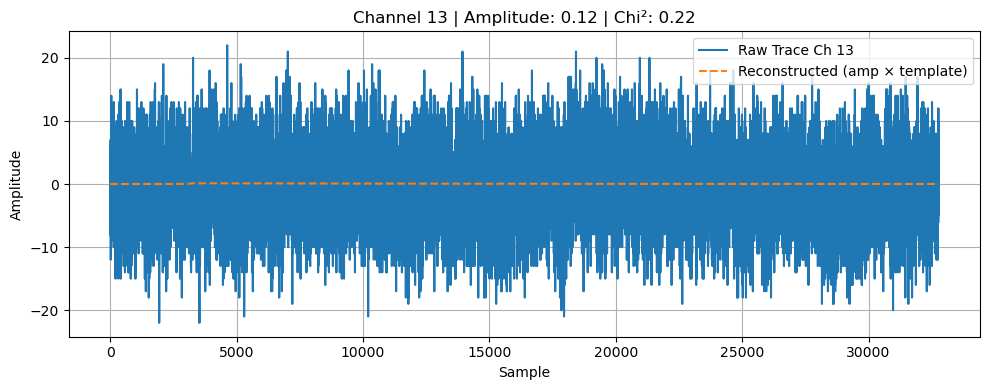

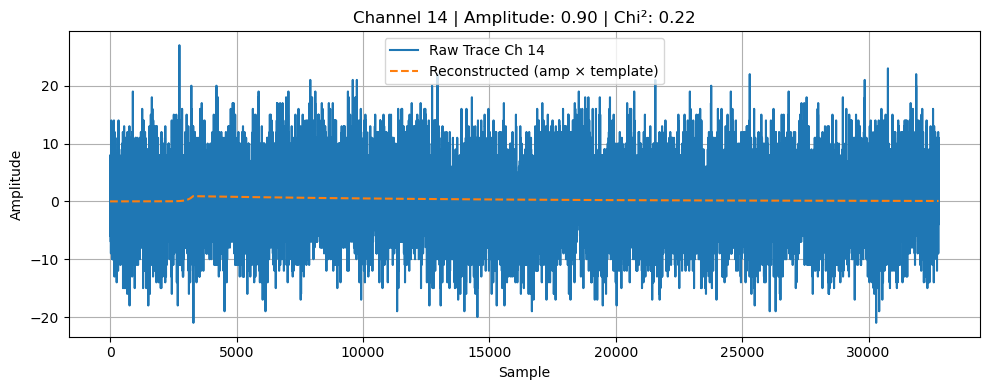

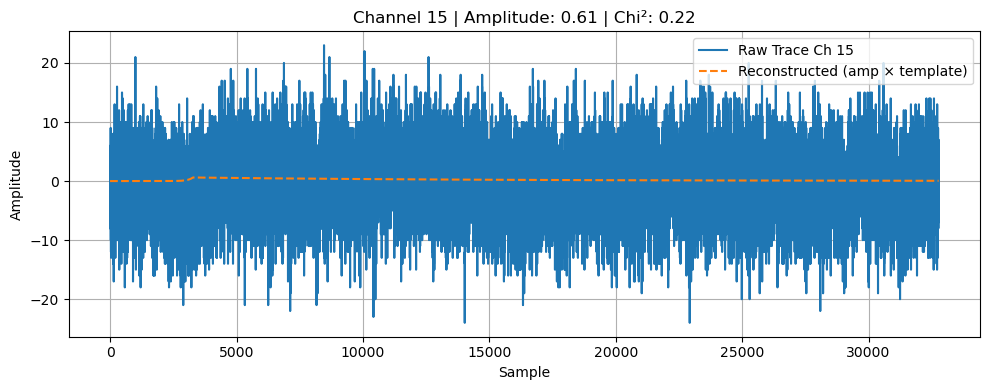

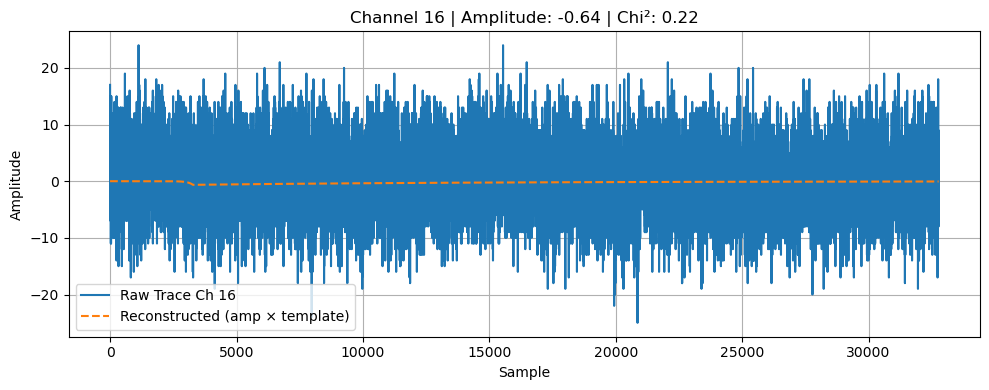

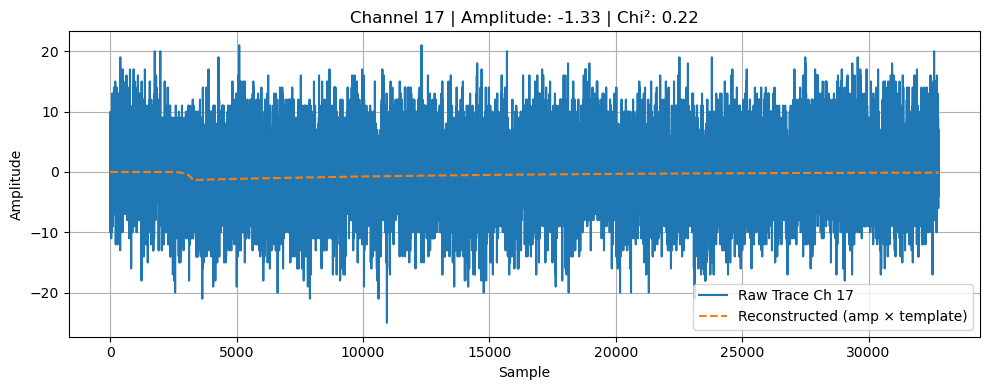

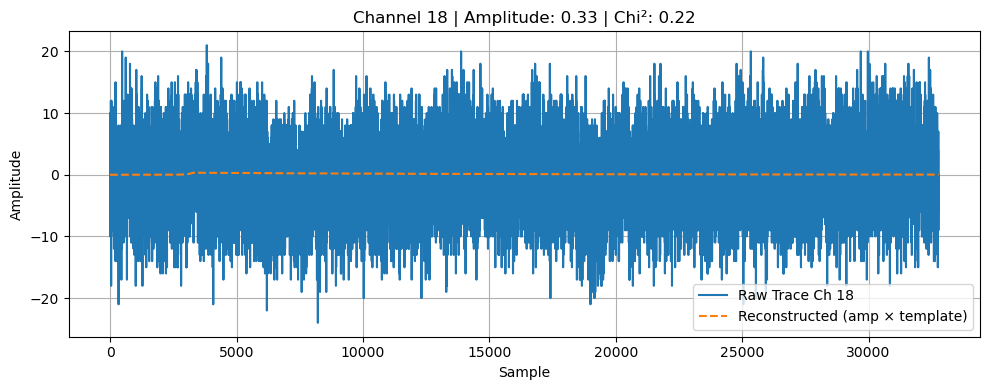

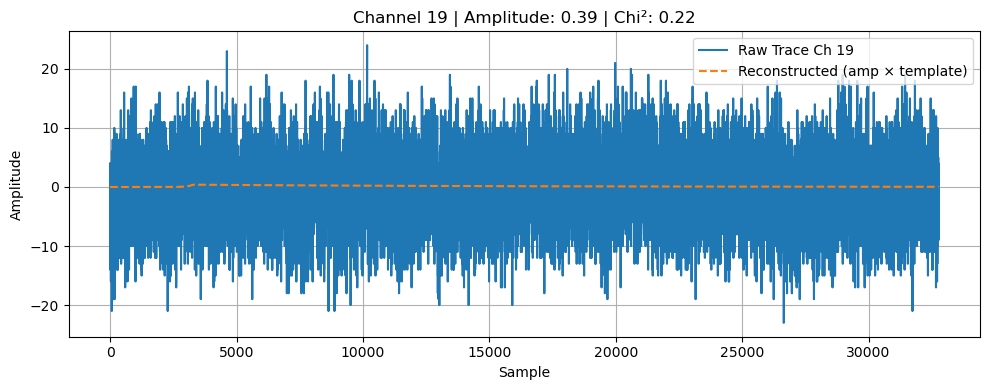

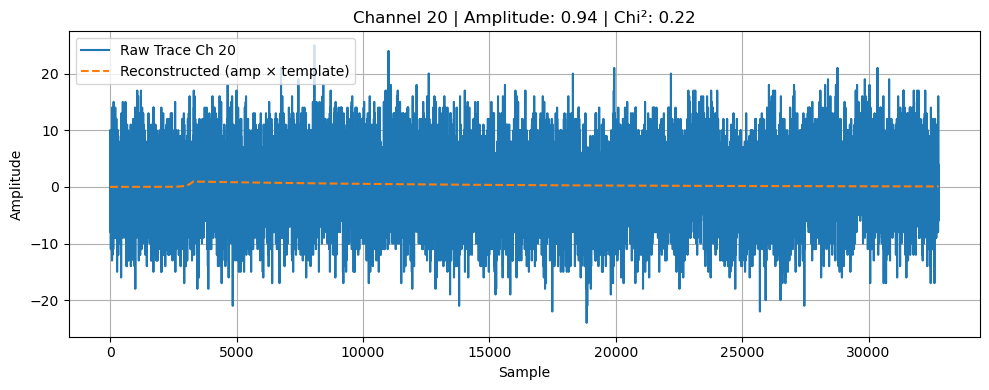

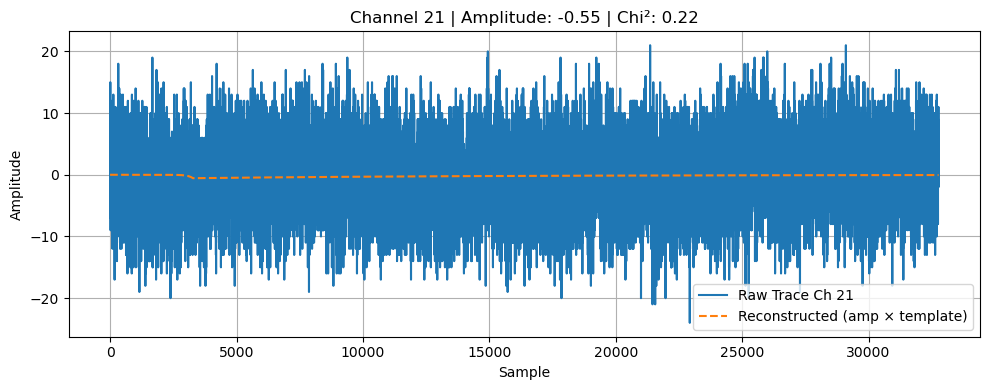

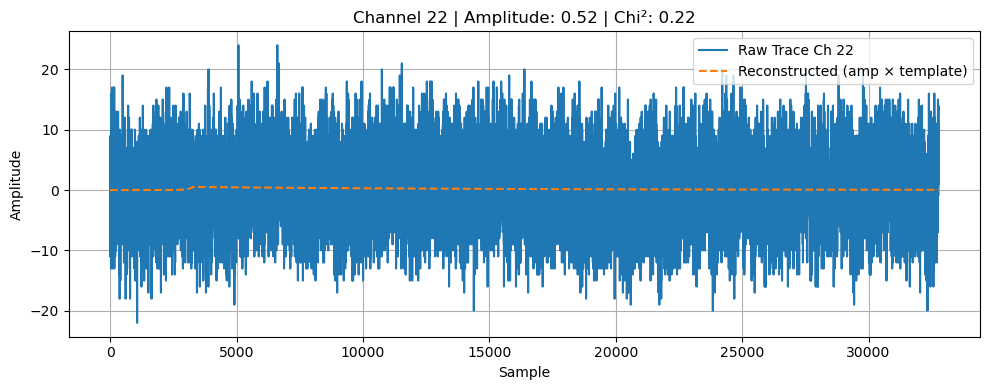

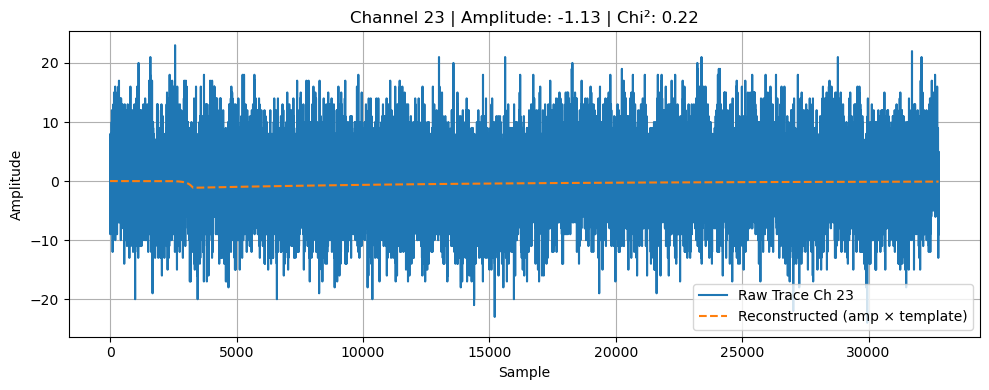

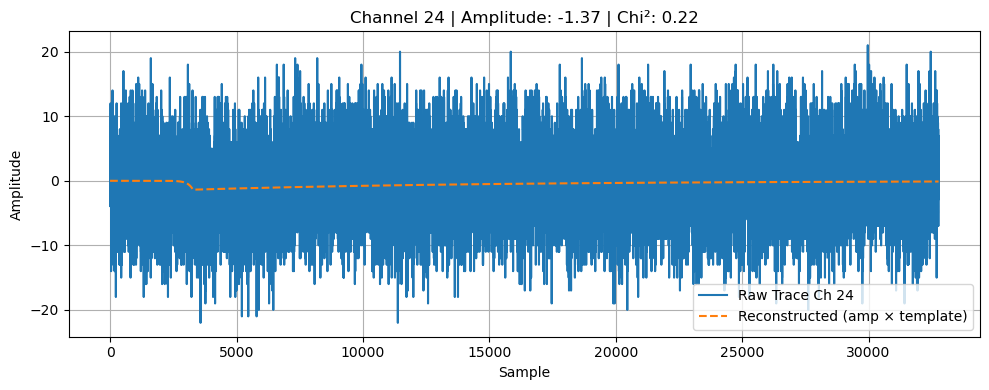

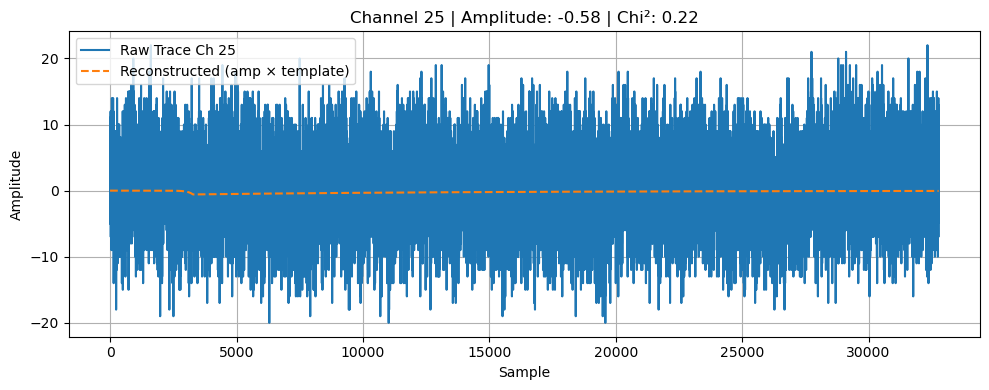

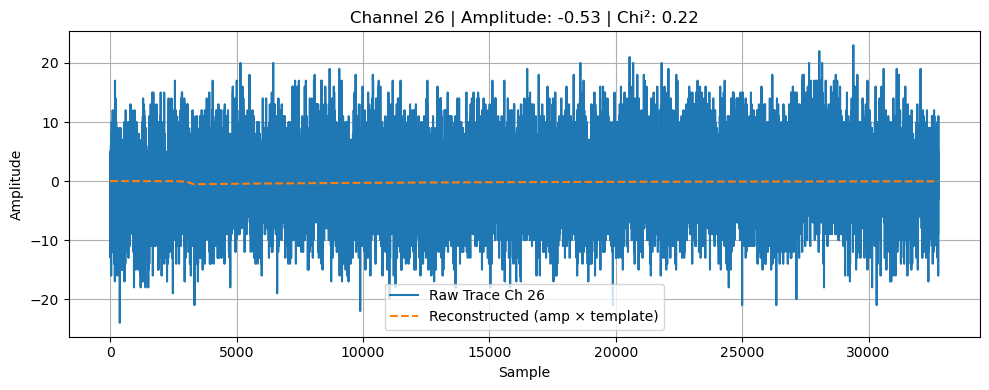

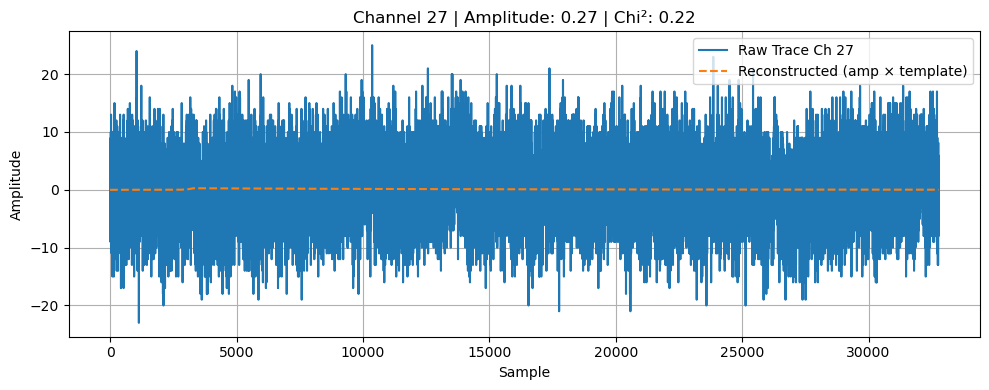

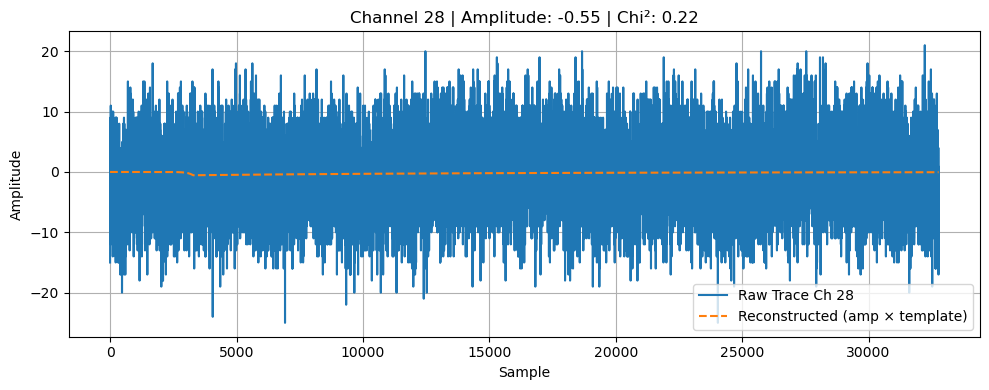

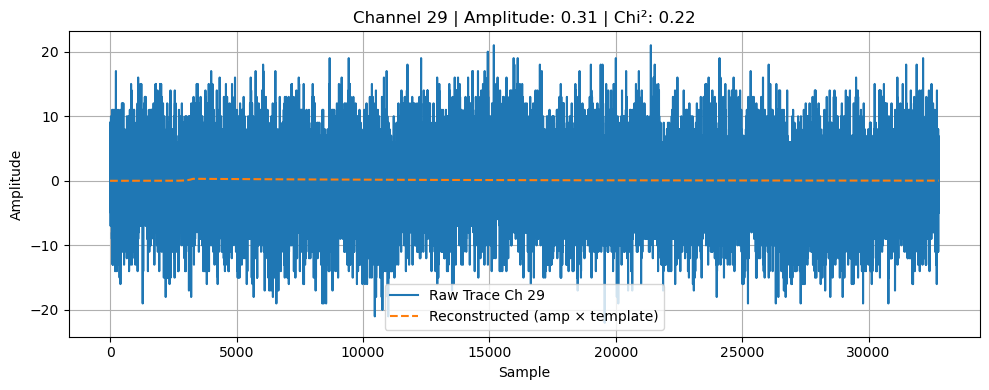

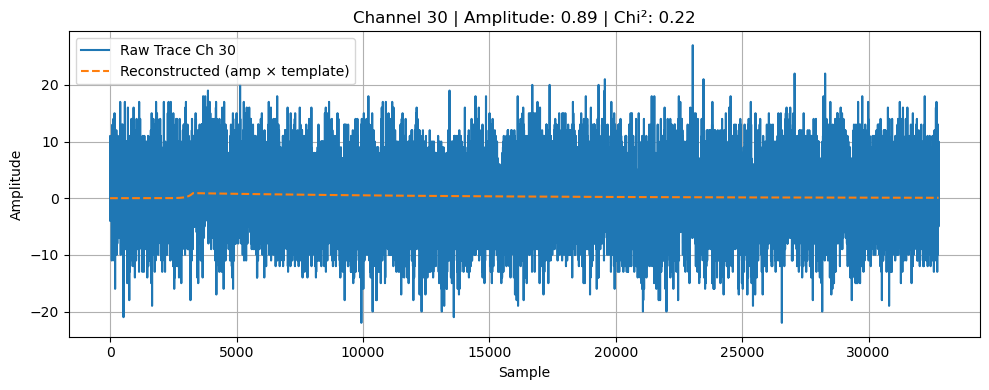

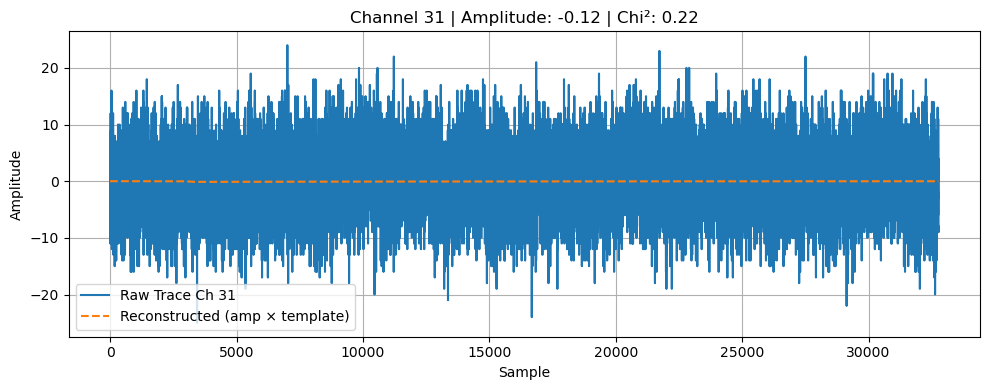

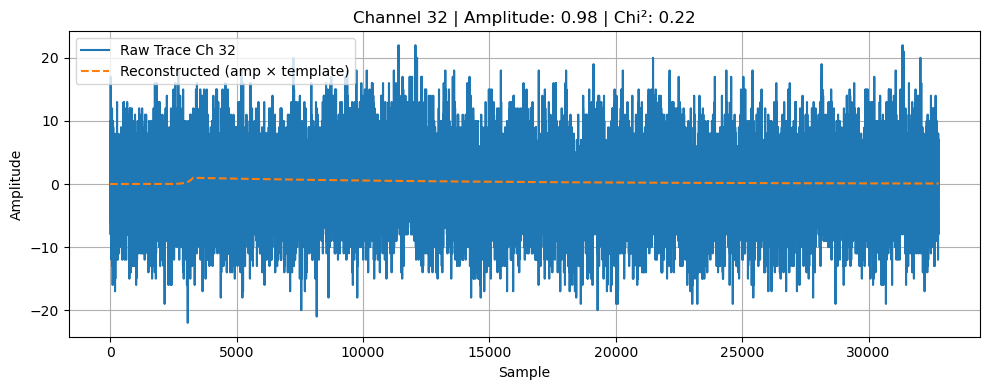

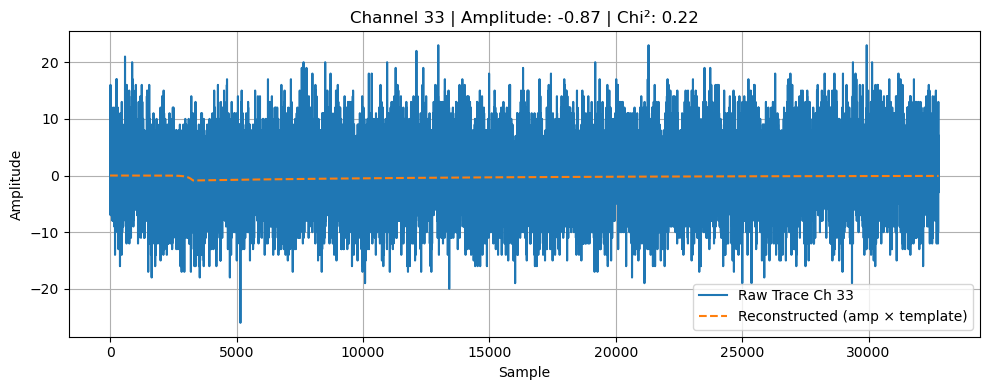

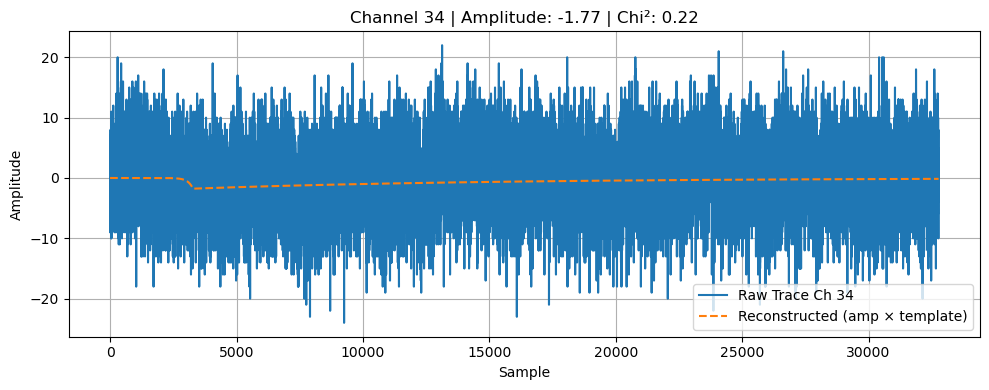

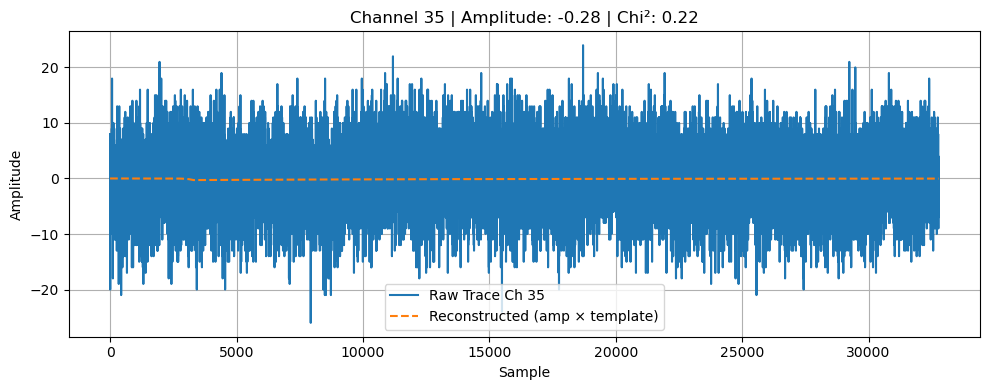

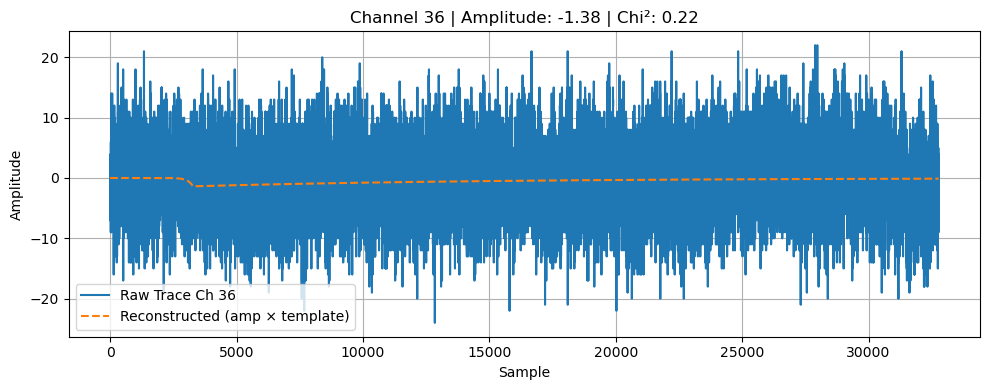

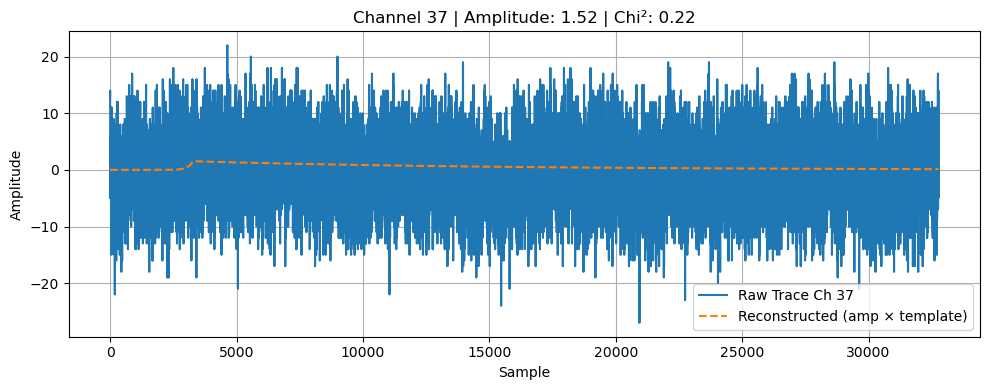

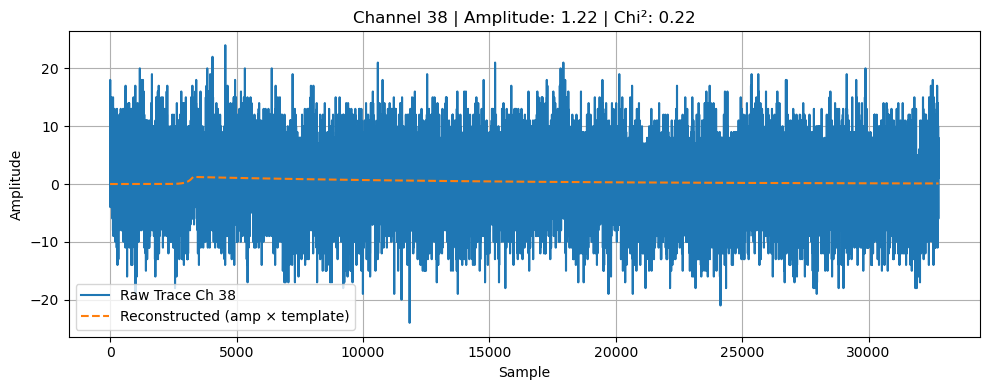

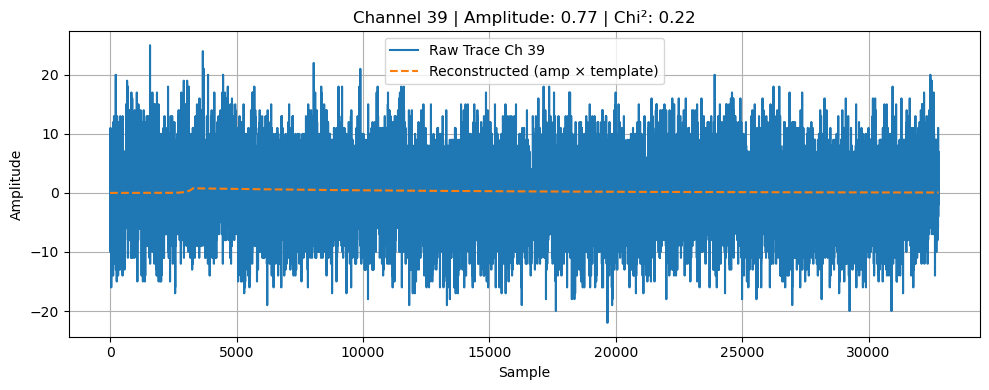

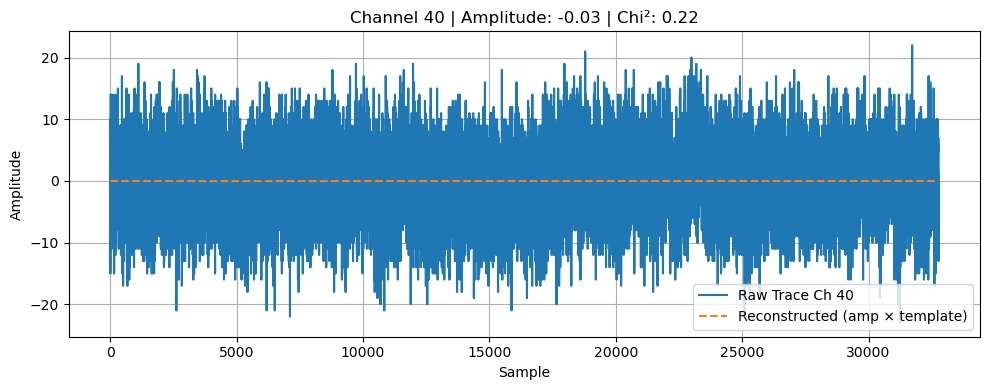

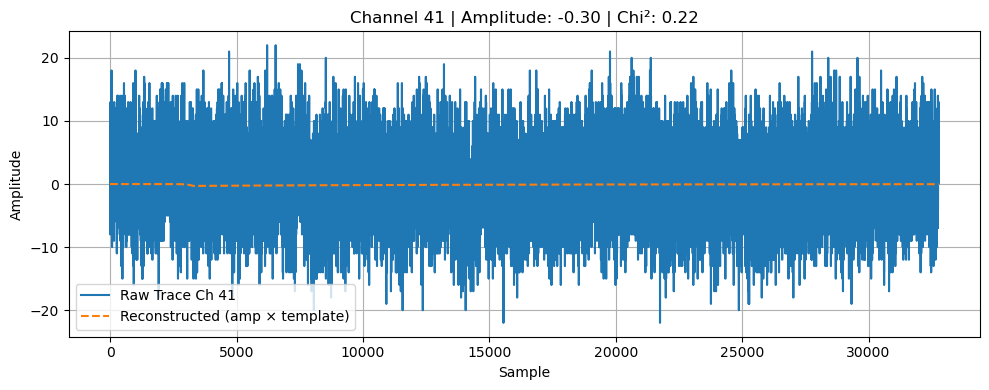

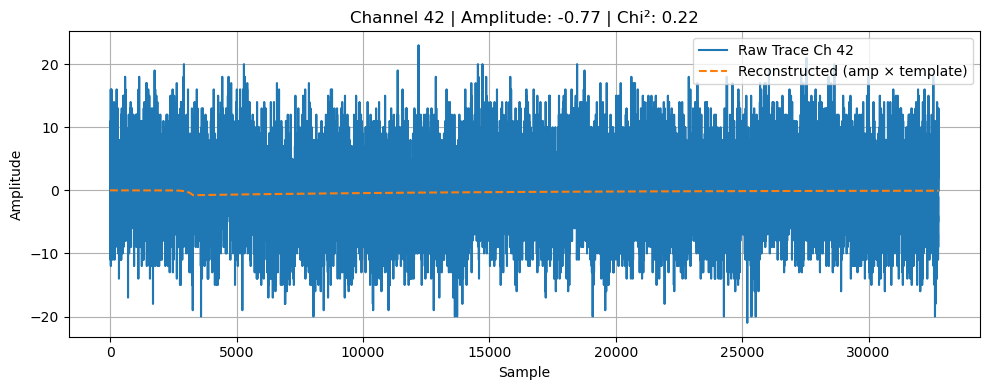

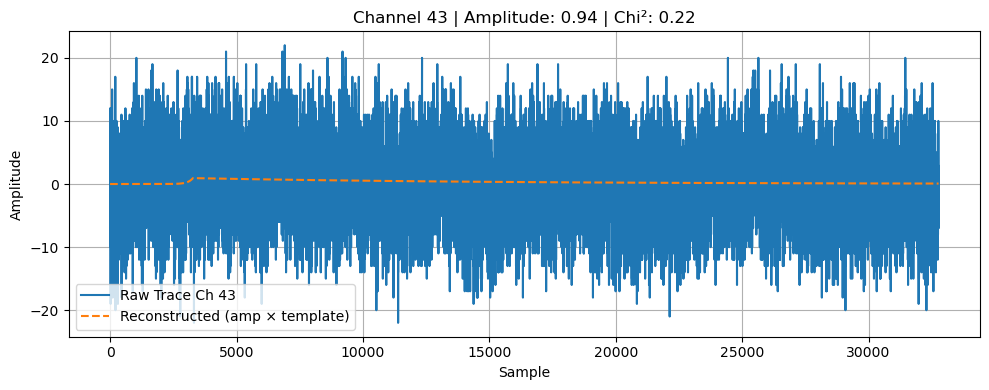

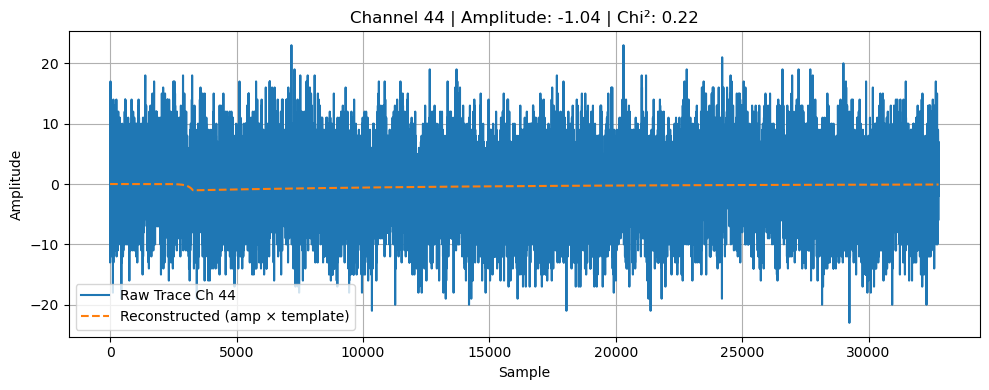

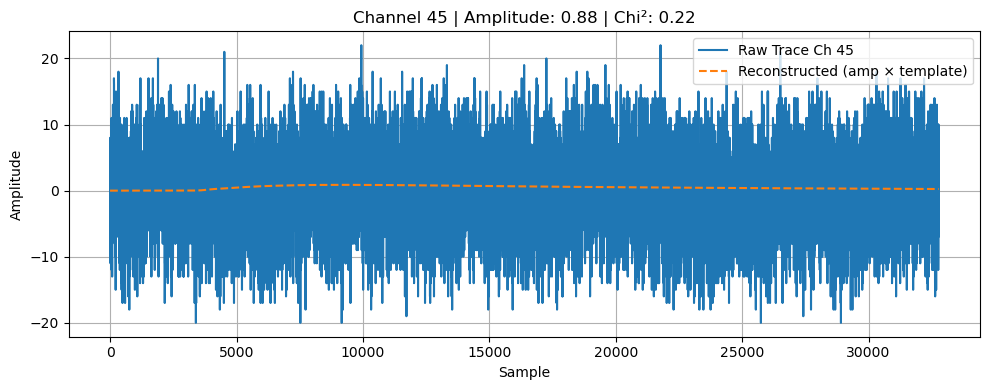

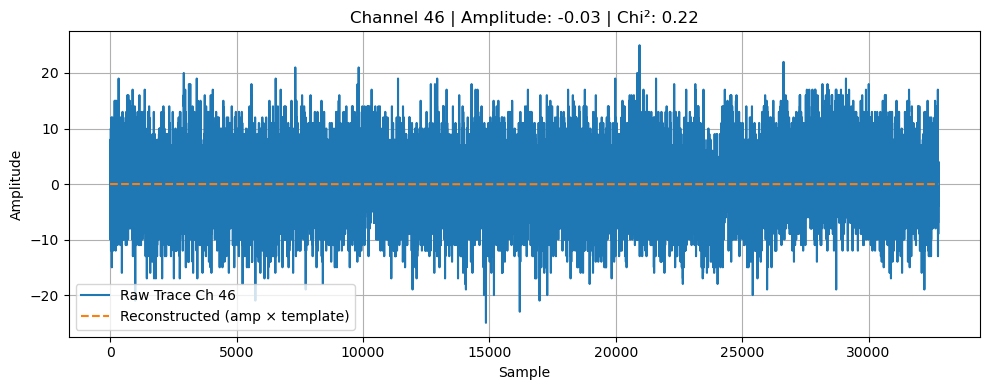

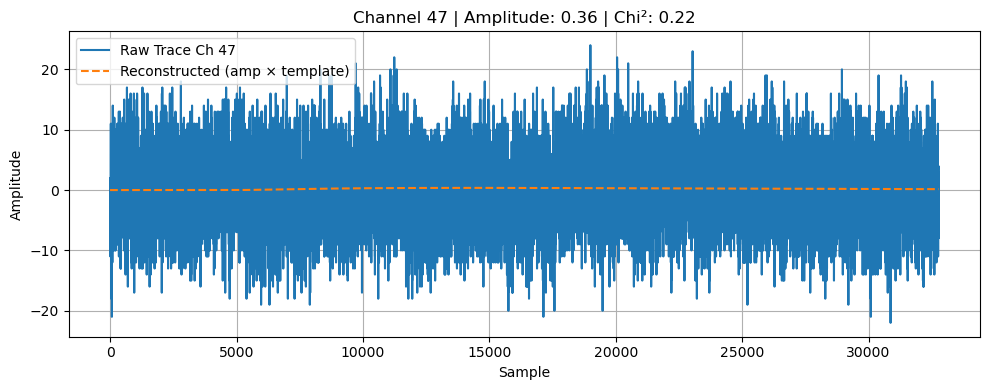

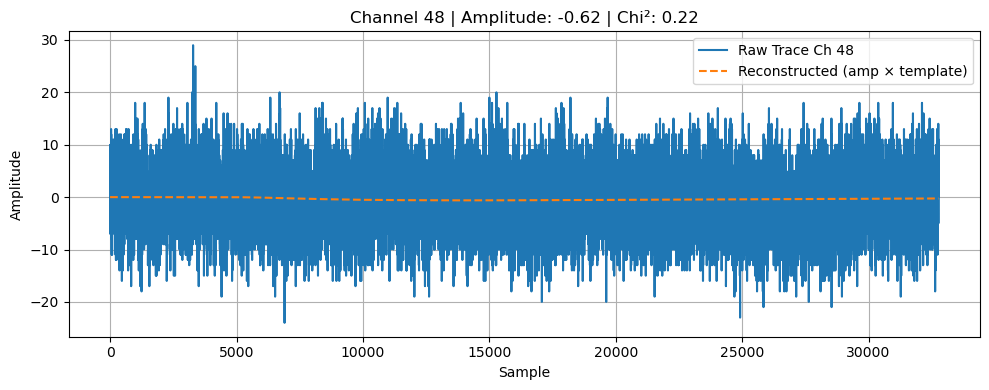

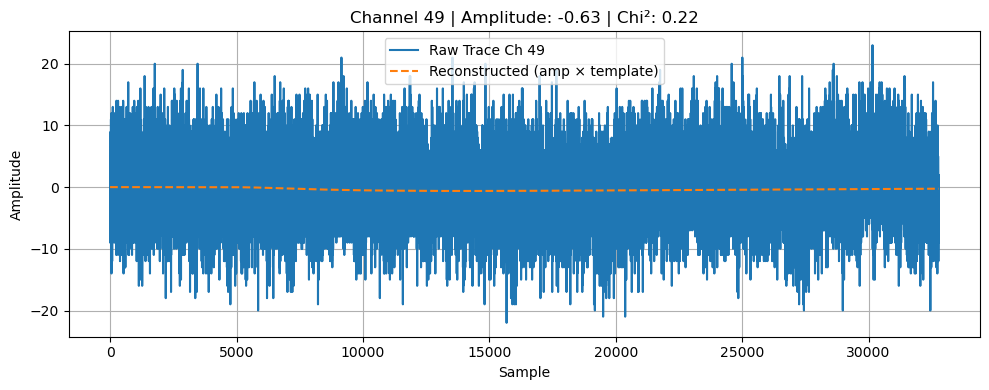

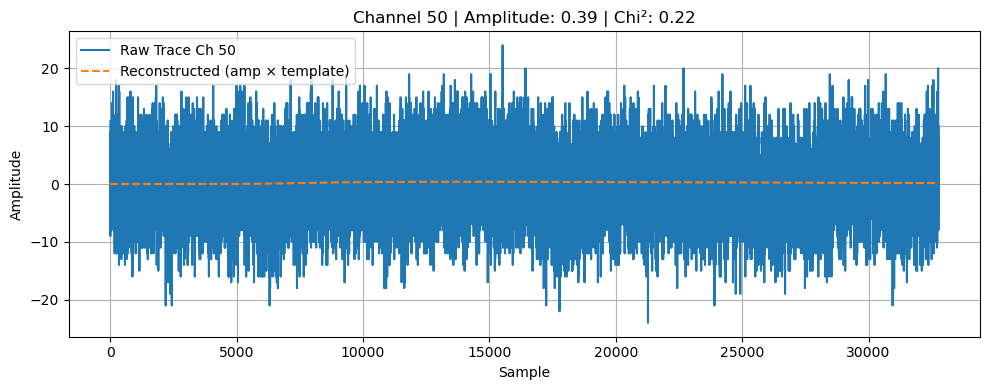

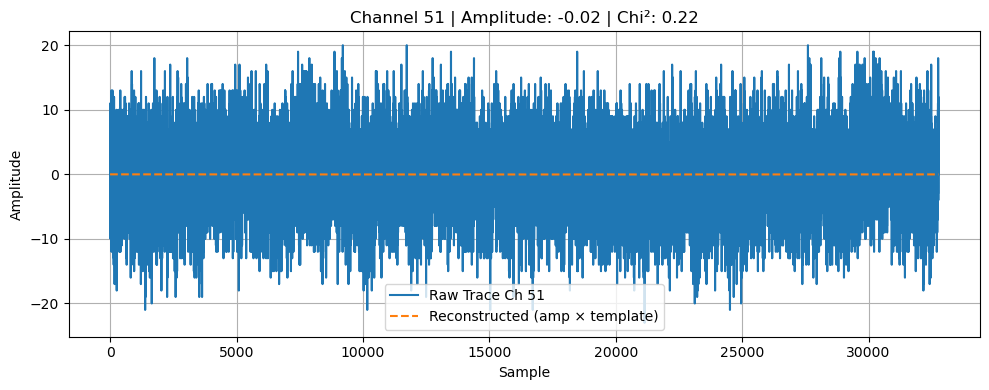

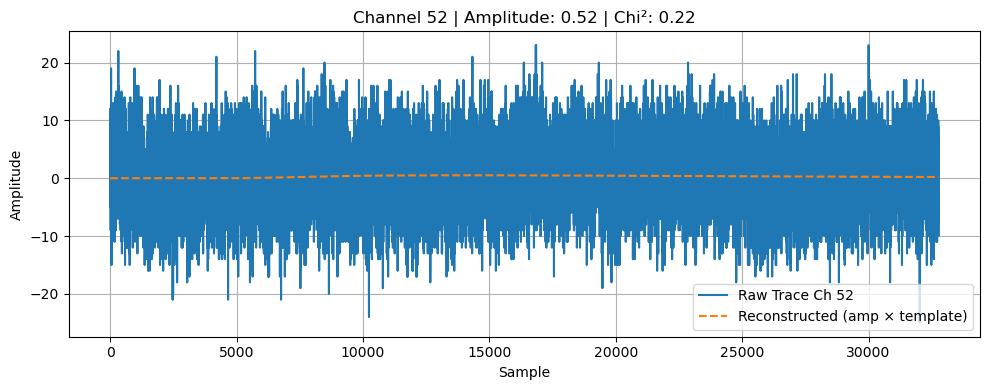

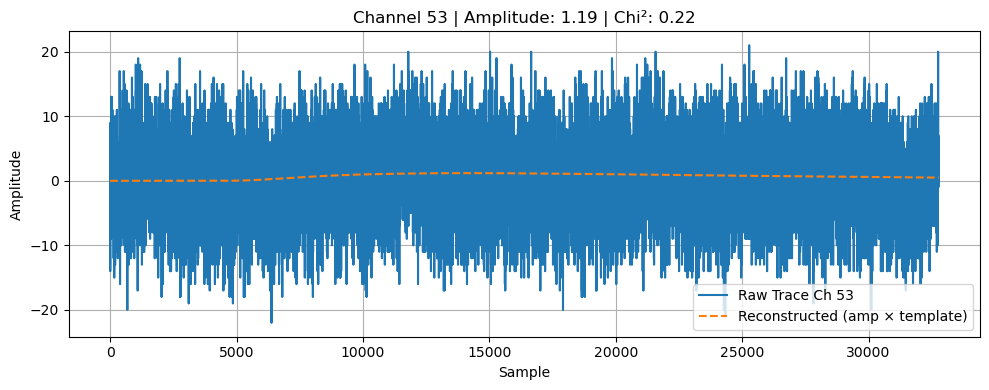

In [7]:
import matplotlib.pyplot as plt

traces = loaded_traces[0]  # shape: (54, trace_length)
amps = np.zeros(54)
chisqs = np.zeros(54)
t0s = np.zeros(54, dtype=int)

# For plotting
templates = {
    "1": trigger_1._template,
    "2": trigger_2._template,
    "3": trigger_3._template,
}

for ch in range(54):
    if ch <= 44:
        amp, chisq = trigger_1.fit(traces[ch])
        template = templates["1"]
    elif ch == 45:
        amp, chisq = trigger_2.fit(traces[ch])
        template = templates["2"]
    else:
        amp, chisq = trigger_3.fit(traces[ch])
        template = templates["3"]

    amps[ch] = amp
    chisqs[ch] = chisq

    # Plot raw trace and reconstructed signal
    plt.figure(figsize=(10, 4))
    plt.plot(traces[ch], label=f'Raw Trace Ch {ch}')
    plt.plot(amp * template, label='Reconstructed (amp × template)', linestyle='--')
    plt.title(f'Channel {ch} | Amplitude: {amp:.2f} | Chi²: {chisq:.2f}')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


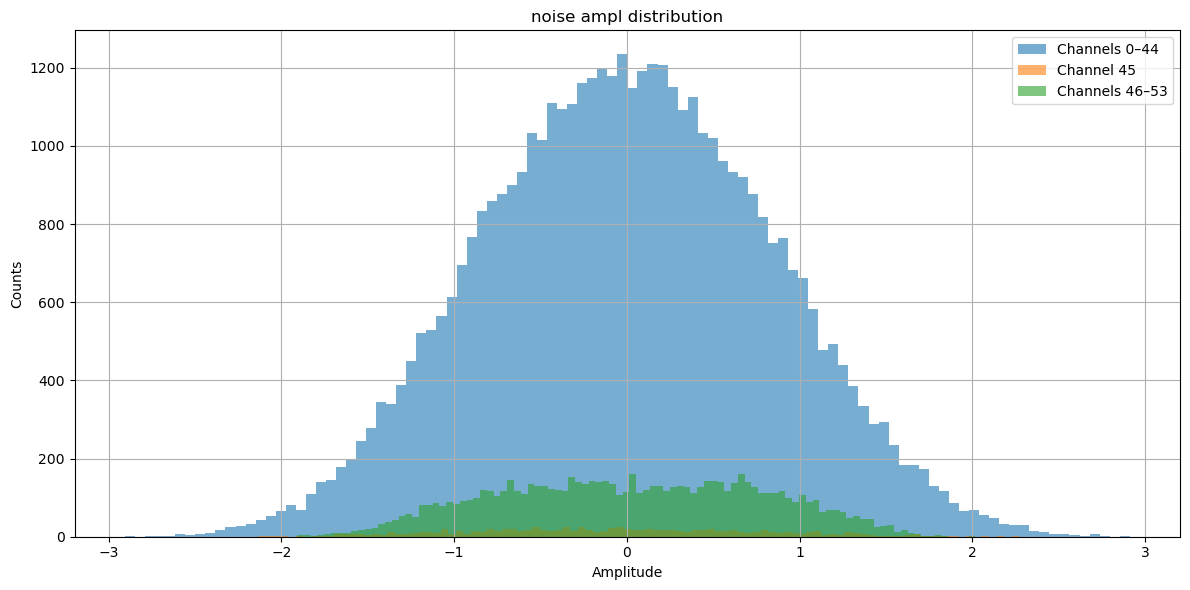

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# loaded_traces should be shape (1000, 54, trace_length)
n_events = len(loaded_traces)
amps_all = np.zeros((n_events, 54))
chisqs_all = np.zeros((n_events, 54))

for i in range(n_events):
    traces = loaded_traces[i]
    for ch in range(54):
        if ch <= 44:
            amp, chisq = trigger_1.fit(traces[ch])
        elif ch == 45:
            amp, chisq = trigger_2.fit(traces[ch])
        else:
            amp, chisq = trigger_3.fit(traces[ch])

        amps_all[i, ch] = amp
        chisqs_all[i, ch] = chisq

# Group amplitude data by channel ranges
amps_sub = amps_all[:, :45].flatten()     # Channels 0–44
amps_45 = amps_all[:, 45]
amps_46plus = amps_all[:, 46:].flatten()  # Channels 46–53

# Plot histograms
plt.figure(figsize=(12, 6))

plt.hist(amps_sub, bins=100, alpha=0.6, label='Channels 0–44')
plt.hist(amps_45, bins=100, alpha=0.6, label='Channel 45')
plt.hist(amps_46plus, bins=100, alpha=0.6, label='Channels 46–53')

plt.xlabel('Amplitude')
plt.ylabel('Counts')
plt.title('noise ampl distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
print("Amplitude stats:")
print(f"Ch 0–44:    mean = {np.mean(amps_sub):.3f}, std = {np.std(amps_sub):.3f}")
print(f"Ch 45:      mean = {np.mean(amps_45):.3f}, std = {np.std(amps_45):.3f}")
print(f"Ch 46–53:   mean = {np.mean(amps_46plus):.3f}, std = {np.std(amps_46plus):.3f}")

Amplitude stats:
Ch 0–44:    mean = -0.002, std = 0.832
Ch 45:      mean = -0.068, std = 0.843
Ch 46–53:   mean = 0.017, std = 0.761


In [18]:
print("Amplitude stats:")
print(f"Ch 0–44:    mean = {np.mean(amps_sub):.3f}, std = {np.std(amps_sub):.3f}")
print(f"Ch 45:      mean = {np.mean(amps_45):.3f}, std = {np.std(amps_45):.3f}")
print(f"Ch 46–53:   mean = {np.mean(amps_46plus):.3f}, std = {np.std(amps_46plus):.3f}")


Amplitude stats:
Ch 0–44:    mean = -0.002, std = 0.832
Ch 45:      mean = -0.068, std = 0.844
Ch 46–53:   mean = 0.017, std = 0.761


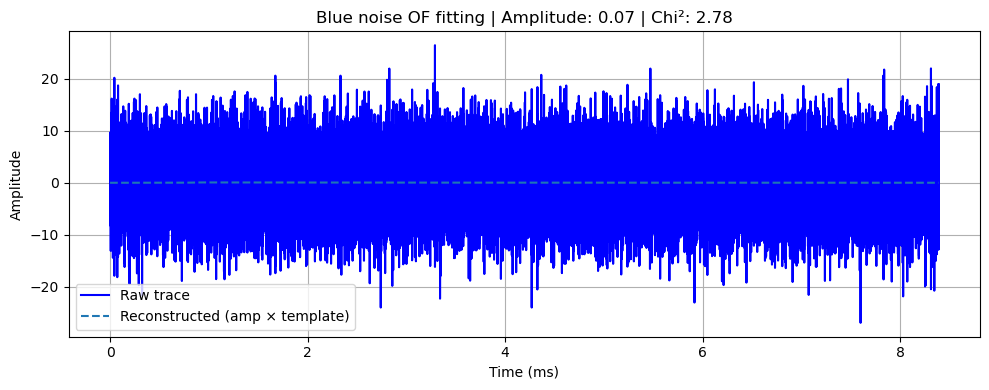

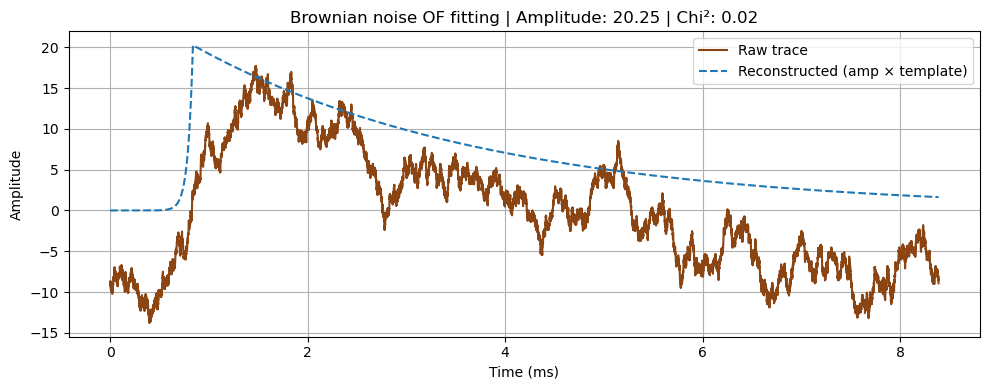

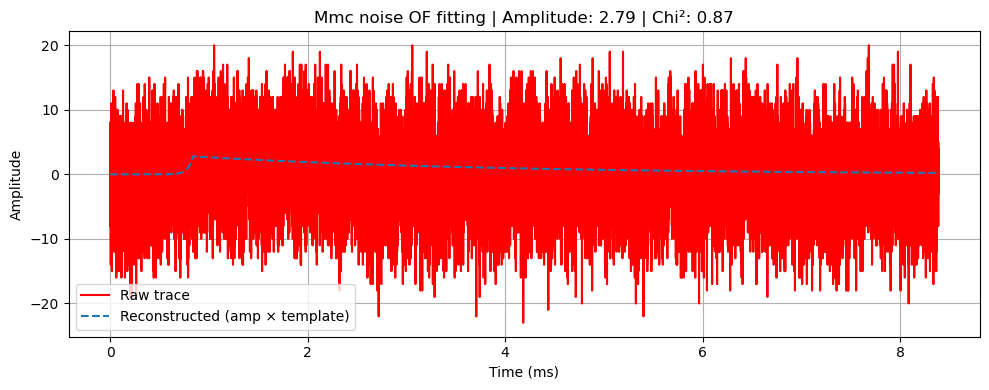

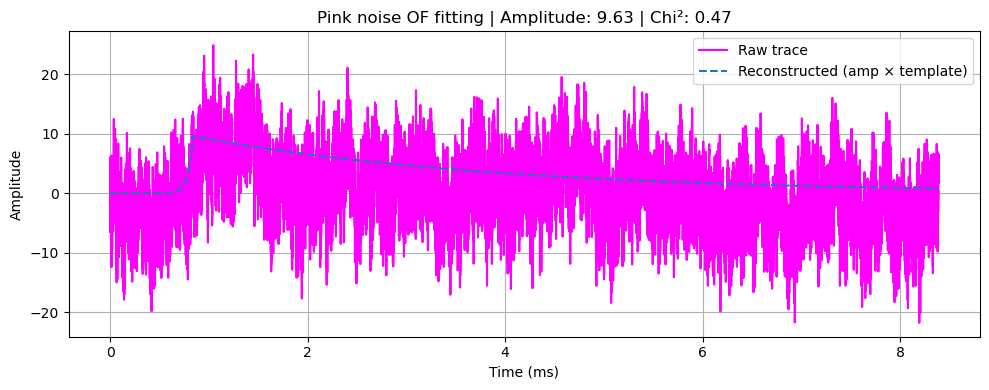

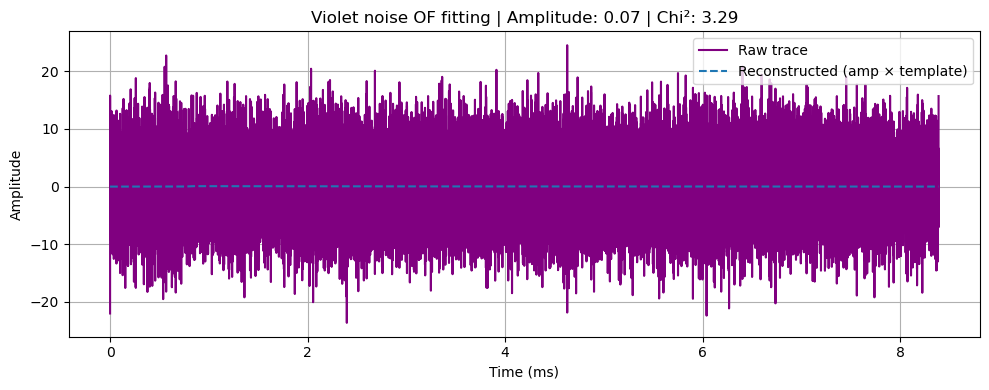

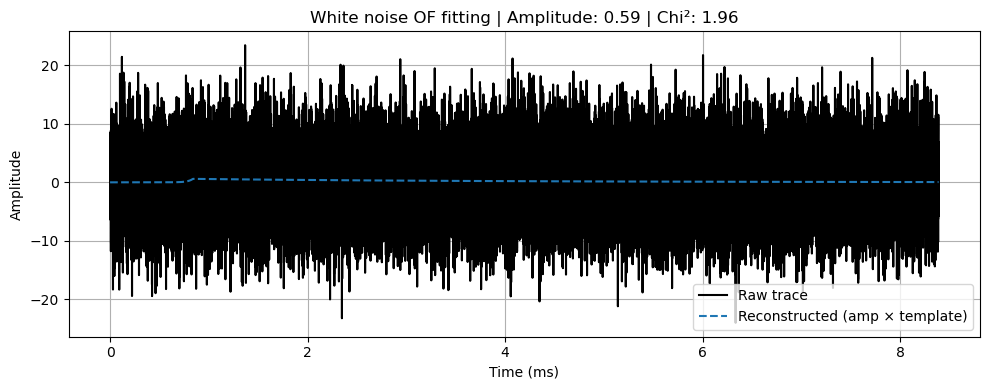

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and noise PSD once
template = np.load("./sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")

# Initialize filter
mmc_trigger = OFtrigger(template, noise_psd, sampling_frequency)
brownian_trigger = OFtrigger(template, "/home/dwong/DELight_mtr/templates/color/noise_psd_brownian.npy", sampling_frequency)
white_trigger = OFtrigger(template, "/home/dwong/DELight_mtr/templates/color/noise_psd_white.npy", sampling_frequency)
blue_trigger = OFtrigger(template, "/home/dwong/DELight_mtr/templates/color/noise_psd_blue.npy", sampling_frequency)
pink_trigger = OFtrigger(template, "/home/dwong/DELight_mtr/templates/color/noise_psd_pink.npy", sampling_frequency)
violet_trigger = OFtrigger(template, "/home/dwong/DELight_mtr/templates/color/noise_psd_violet.npy", sampling_frequency)

# Define directory and file names
noise_dir = "/ceph/dwong/trigger_samples/noise_traces"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Color mapping for raw traces
color_map = {
    'white': 'black',
    'pink': 'magenta',
    'brownian': 'saddlebrown',
    'blue': 'blue',
    'violet': 'purple',
    'mmc': 'red',  # Default/fallback color
}

# Function to process a noise file
def process_noise_file(filepath, label):
    traces = load_traces_from_zstd(filepath, n_traces=100)
    max_amp = -np.inf
    best_trace = None
    best_template = None
    best_ch = -1
    best_idx = -1
    best_chisq = None

    for trace_idx, trace_set in enumerate(traces):  # 100 sets
        for ch in range(54):  # 54 channels
            amp, chisq = trigger.fit(trace_set[ch])
            if amp > max_amp:
                max_amp = amp
                best_trace = trace_set[ch]
                best_ch = ch
                best_idx = trace_idx
                best_chisq = chisq

    # Plot the best trace
    color = color_map.get(label.lower(), 'gray')
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, best_trace, label='Raw trace', color=color)
    plt.plot(time_axis, max_amp * best_template, label='Reconstructed (amp × template)', linestyle='--')
    plt.title(f'{label.capitalize()} noise OF fitting | Amplitude: {max_amp:.2f} | Chi²: {best_chisq * 4:.2f}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Loop through all noise types
for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "")
    process_noise_file(full_path, label)


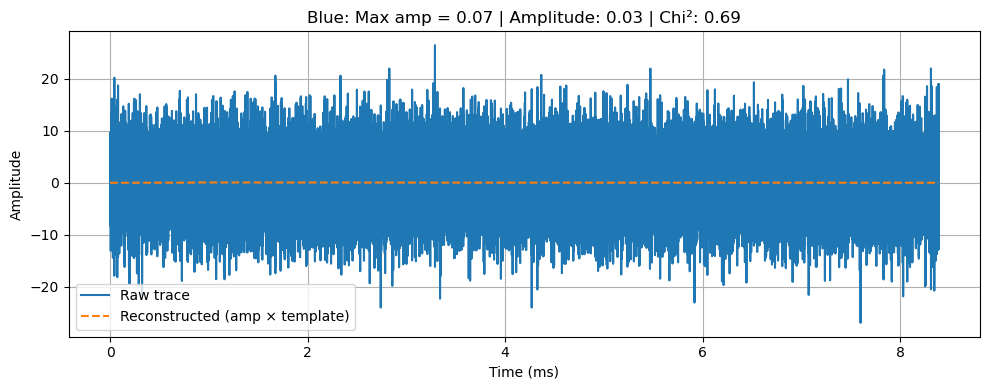

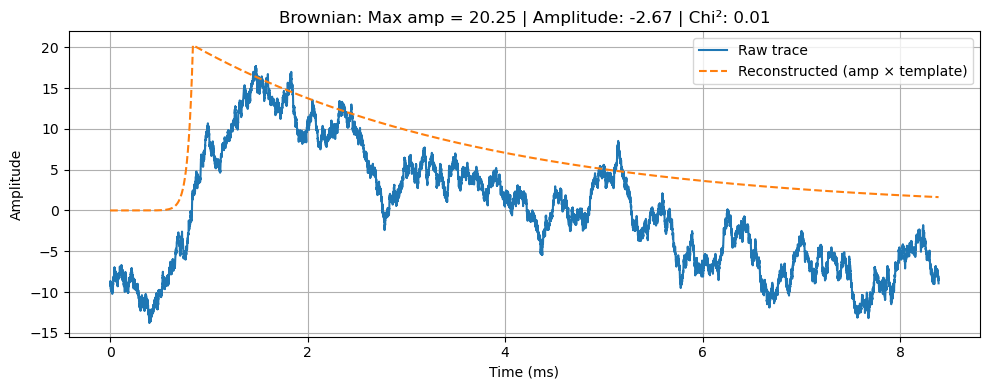

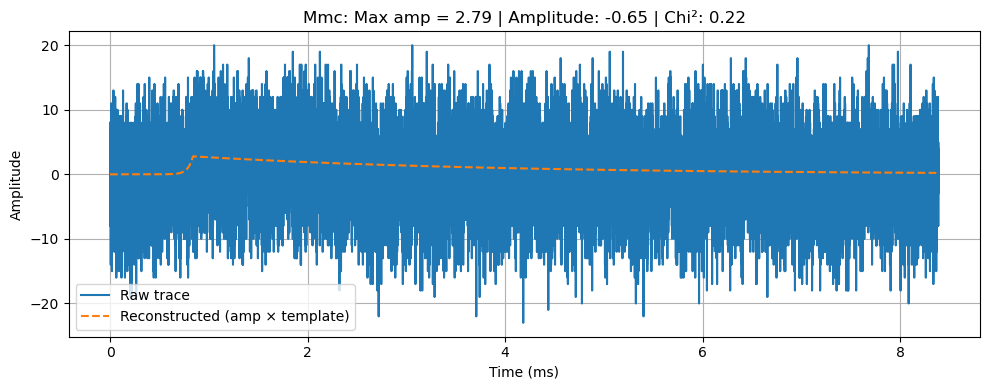

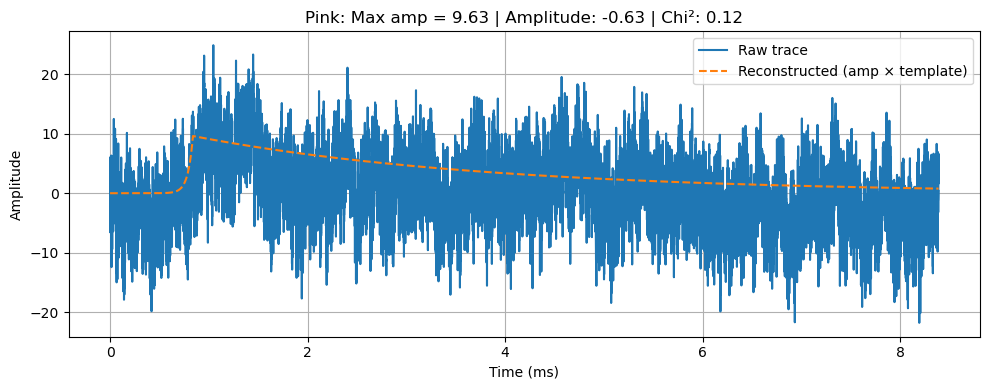

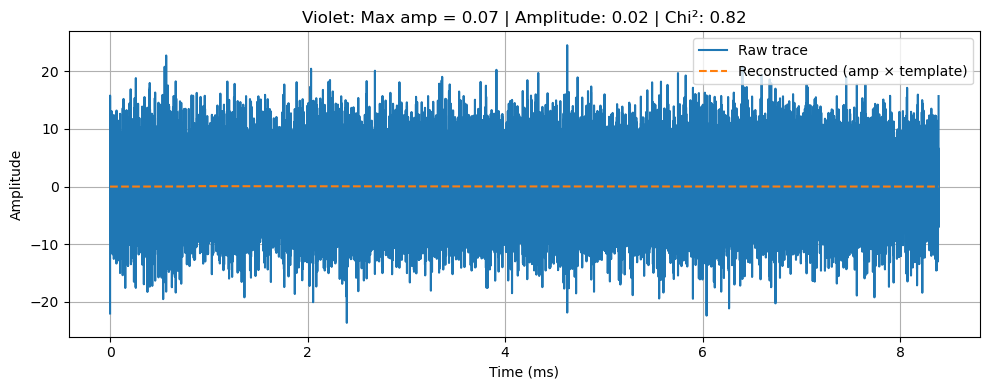

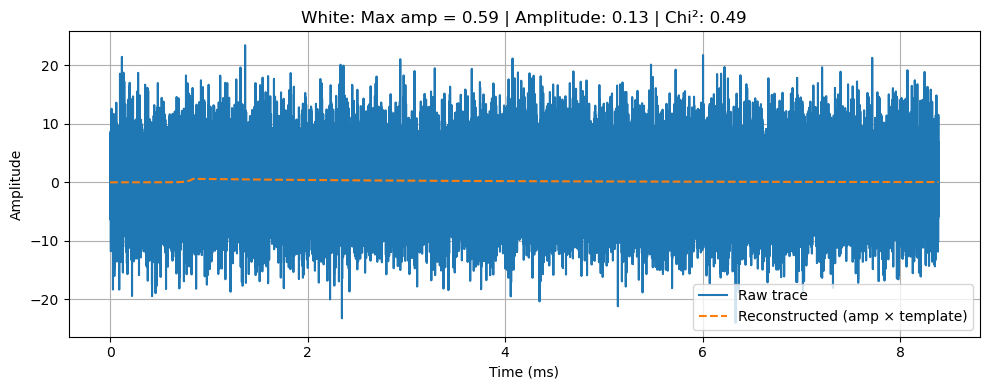

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and noise PSD once
template = np.load("./sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")

# Initialize filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)

# Define directory and file names
noise_dir = "/ceph/dwong/trigger_samples/noise_traces"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Function to process a noise file
def process_noise_file(filepath, label):
    traces = load_traces_from_zstd(filepath, n_traces=100)
    max_amp = -np.inf
    best_trace = None
    best_template = None
    best_ch = -1
    best_idx = -1

    for trace_idx, trace_set in enumerate(traces):  # 100 sets
        for ch in range(54):  # 54 channels
            amp, chisq = trigger.fit(trace_set[ch])
            if amp > max_amp:
                max_amp = amp
                best_trace = trace_set[ch]
                best_template = trigger._template
                best_ch = ch
                best_idx = trace_idx

    # Plot the best trace
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, best_trace, label='Raw trace')
    plt.plot(time_axis, max_amp * best_template, label='Reconstructed (amp × template)', linestyle='--')
    plt.title(f'{label}: Max amp = {max_amp:.2f} | Amplitude: {amp:.2f} | Chi²: {chisq:.2f}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Loop through all noise types
for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "").capitalize()
    process_noise_file(full_path, label)


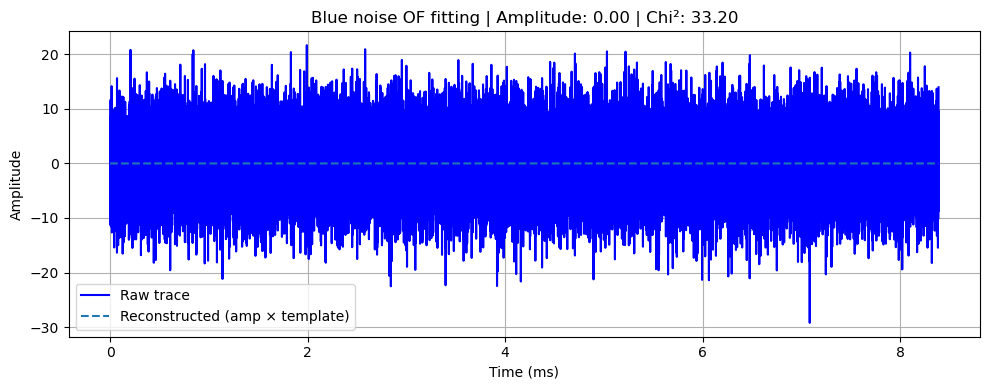

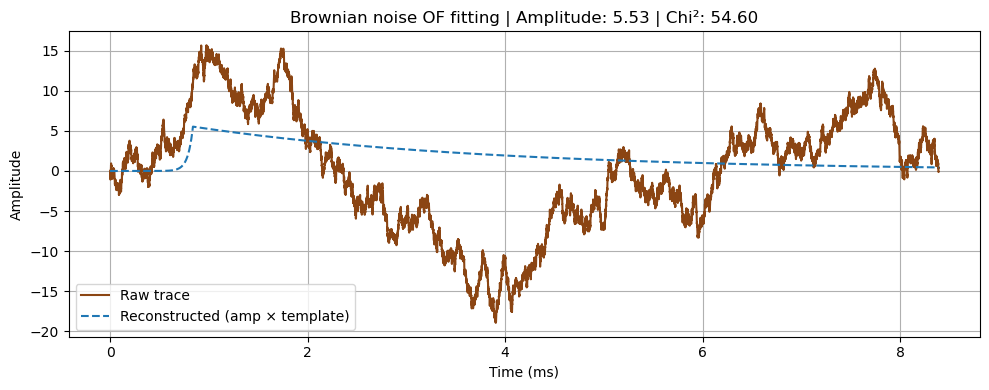

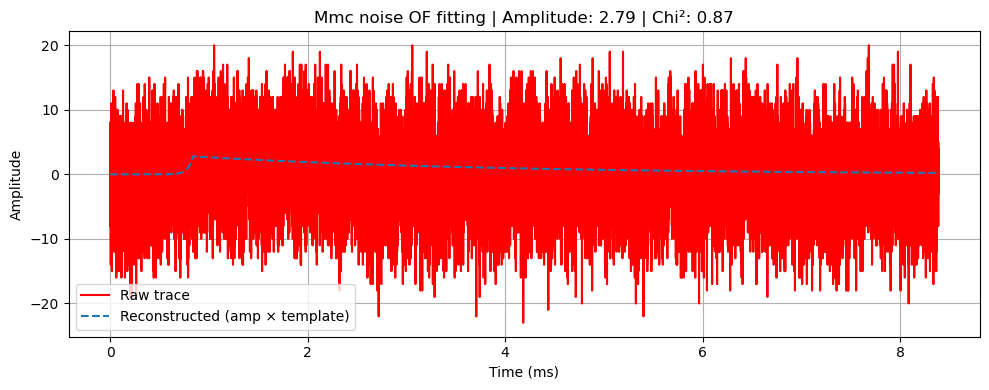

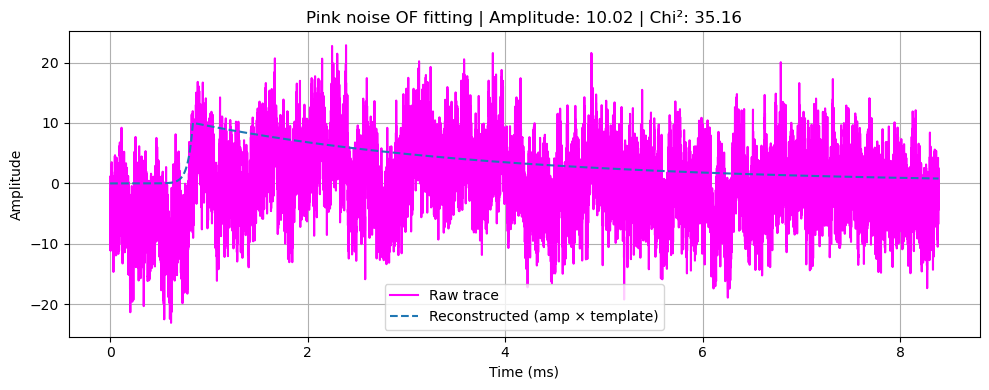

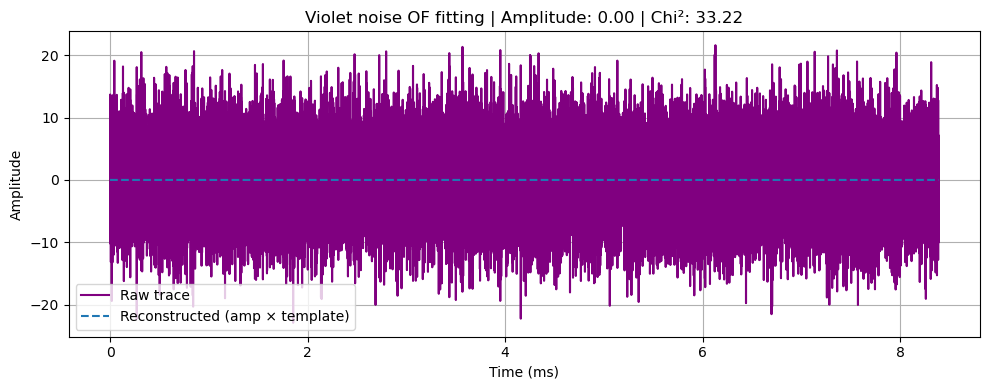

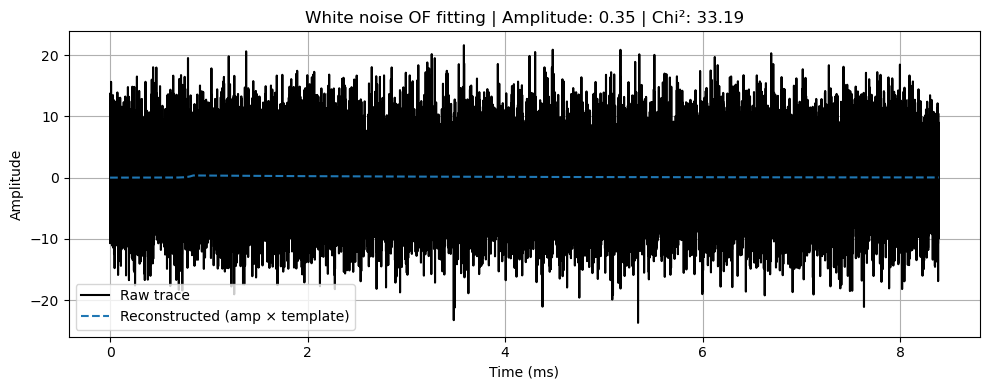

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assumptions
sampling_frequency = 3906250  # Hz
dt_ms = 1e3 / sampling_frequency  # Time step in ms
time_axis = np.arange(32768) * dt_ms  # Assuming traces have length 32768

# Load template and all PSDs
template = np.load("./sub_ch_template.npy")
mmc_psd = np.load("../../templates/noise_psd_from_MMC.npy")
brownian_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_brownian.npy")
white_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_white.npy")
blue_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_blue.npy")
pink_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_pink.npy")
violet_psd = np.load("/home/dwong/DELight_mtr/templates/color/noise_psd_violet.npy")

# Initialize filters
mmc_trigger = OFtrigger(template, mmc_psd, sampling_frequency)
brownian_trigger = OFtrigger(template, brownian_psd, sampling_frequency)
white_trigger = OFtrigger(template, white_psd, sampling_frequency)
blue_trigger = OFtrigger(template, blue_psd, sampling_frequency)
pink_trigger = OFtrigger(template, pink_psd, sampling_frequency)
violet_trigger = OFtrigger(template, violet_psd, sampling_frequency)

# Map labels to corresponding triggers
trigger_map = {
    'mmc': mmc_trigger,
    'brownian': brownian_trigger,
    'white': white_trigger,
    'blue': blue_trigger,
    'pink': pink_trigger,
    'violet': violet_trigger,
}

# Color mapping for raw traces
color_map = {
    'white': 'black',
    'pink': 'magenta',
    'brownian': 'saddlebrown',
    'blue': 'blue',
    'violet': 'purple',
    'mmc': 'red',  # Default/fallback color
}

# Function to process a noise file
def process_noise_file(filepath, label):
    trigger = trigger_map[label]
    traces = load_traces_from_zstd(filepath, n_traces=100)
    max_amp = -np.inf
    best_trace = None
    best_template = template
    best_ch = -1
    best_idx = -1
    best_chisq = None

    for trace_idx, trace_set in enumerate(traces):  # 100 sets
        for ch in range(54):  # 54 channels
            amp, chisq = trigger.fit(trace_set[ch])
            if amp > max_amp:
                max_amp = amp
                best_trace = trace_set[ch]
                best_ch = ch
                best_idx = trace_idx
                best_chisq = chisq

    # Plot the best trace
    color = color_map.get(label.lower(), 'gray')
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, best_trace, label='Raw trace', color=color)
    plt.plot(time_axis, max_amp * best_template, label='Reconstructed (amp × template)', linestyle='--')
    plt.title(f'{label.capitalize()} noise OF fitting | Amplitude: {max_amp:.2f} | Chi²: {best_chisq * 4:.2f}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define directory and file names
noise_dir = "/ceph/dwong/trigger_samples/noise_traces"
noise_files = [
    "blue_noise_traces.zst",
    "brownian_noise_traces.zst",
    "mmc_noise_traces.zst",
    "pink_noise_traces.zst",
    "violet_noise_traces.zst",
    "white_noise_traces.zst",
]

# Loop through all noise types
for filename in noise_files:
    full_path = os.path.join(noise_dir, filename)
    label = filename.replace("_noise_traces.zst", "")
    process_noise_file(full_path, label)
